<a href="https://colab.research.google.com/github/vasanthk99/Assignment_3/blob/main/assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
import torch
from transformers import AlbertTokenizer, AlbertForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import pandas as pd
from collections import Counter
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import precision_recall_curve, average_precision_score
from itertools import cycle
from sklearn.metrics import precision_score, recall_score
nltk.download('stopwords', quiet=True)

# Load the AG News dataset
dataset = load_dataset("ag_news")

# Define category names
id2label = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
label2id = {v: k for k, v in id2label.items()}



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
# Load pre-trained ALBERT tokenizer and model
model_name = "albert-base-v2"
tokenizer = AlbertTokenizer.from_pretrained(model_name)
model = AlbertForSequenceClassification.from_pretrained(model_name, num_labels=4)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

# Split the dataset
train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(10000))
eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
# Define metric function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {'accuracy': acc, 'f1': f1}

In [ ]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
print("Training")
trainer.train()

# Evaluate the model
print("Evaluating ")
eval_results = trainer.evaluate()
print(eval_results)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Training


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.674900,0.445901,0.862000,0.860700
2,0.332000,0.336750,0.896000,0.896125
3,0.298900,0.323572,0.917000,0.917075


Evaluating 


{'eval_loss': 0.32357195019721985, 'eval_accuracy': 0.917, 'eval_f1': 0.9170753360234049, 'eval_runtime': 7.6246, 'eval_samples_per_second': 131.154, 'eval_steps_per_second': 2.098, 'epoch': 3.0}


In [ ]:
# Get predictions for the evaluation dataset
print("Getting predictions")
predictions = trainer.predict(eval_dataset)
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids

Getting predictions


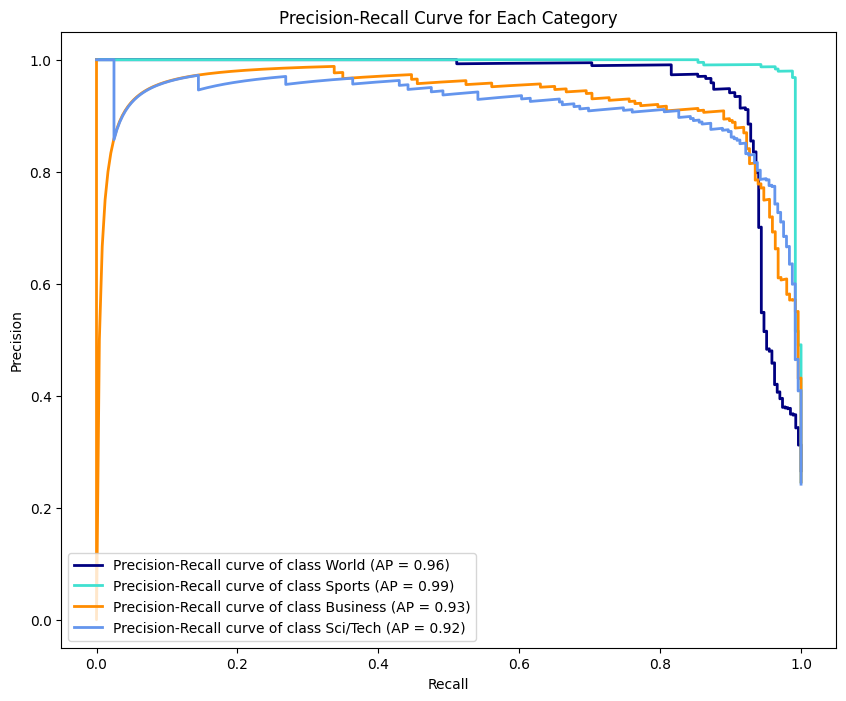

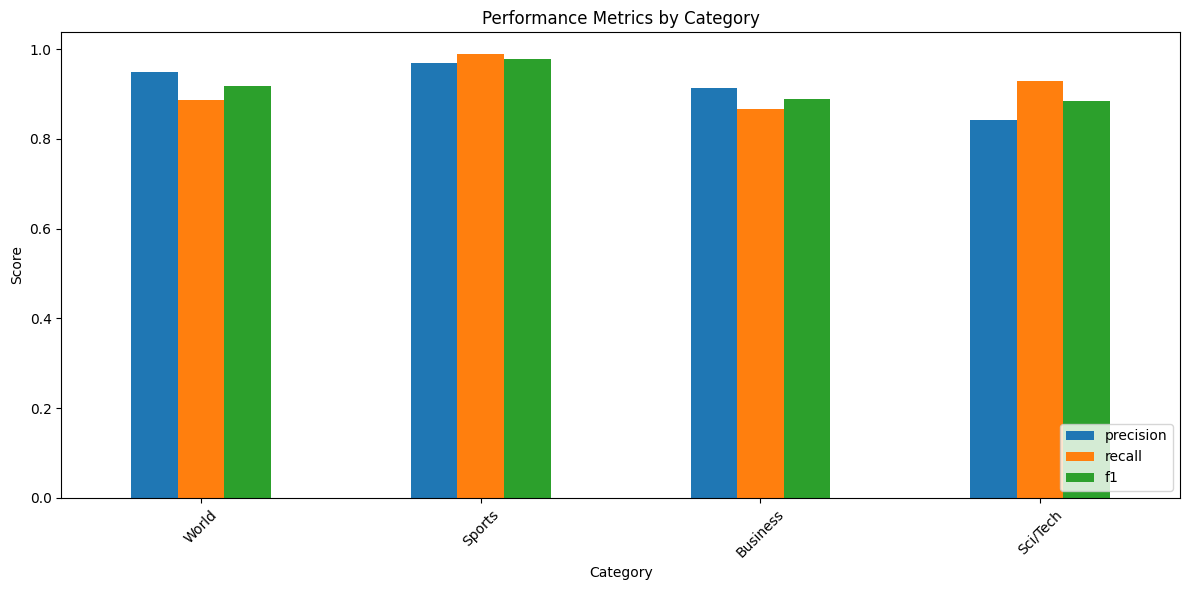

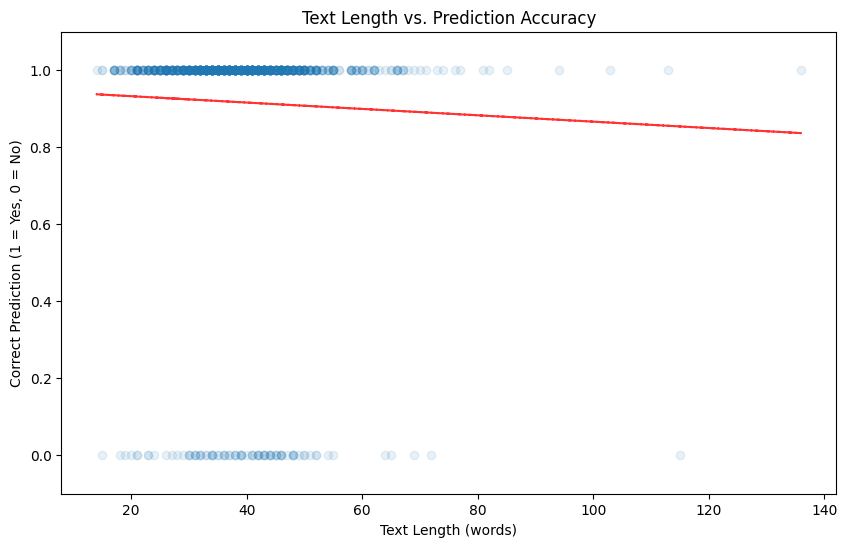

In [ ]:
plt.figure(figsize=(10, 8))
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(4), colors):
    precision, recall, _ = precision_recall_curve(labels == i, predictions.predictions[:, i])
    average_precision = average_precision_score(labels == i, predictions.predictions[:, i])
    plt.plot(recall, precision, color=color, lw=2,
             label=f'Precision-Recall curve of class {id2label[i]} (AP = {average_precision:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Category')
plt.legend(loc="lower left")
plt.show()

# Category-wise performance metrics
category_metrics = {}
for i in range(4):
    category_metrics[id2label[i]] = {
        'precision': precision_score(labels == i, preds == i, average='binary'),
        'recall': recall_score(labels == i, preds == i, average='binary'),
        'f1': f1_score(labels == i, preds == i, average='binary')
    }

metrics_df = pd.DataFrame(category_metrics).transpose()
plt.figure(figsize=(12, 6))
metrics_df.plot(kind='bar', ax=plt.gca())
plt.title('Performance Metrics by Category')
plt.xlabel('Category')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Text length vs. Prediction accuracy
eval_texts = dataset['test'].select(range(1000))['text']  # Match the size of eval_dataset
text_lengths = [len(text.split()) for text in eval_texts]
correct_predictions = labels == preds

plt.figure(figsize=(10, 6))
plt.scatter(text_lengths, correct_predictions, alpha=0.1)
plt.title('Text Length vs. Prediction Accuracy')
plt.xlabel('Text Length (words)')
plt.ylabel('Correct Prediction (1 = Yes, 0 = No)')
plt.ylim(-0.1, 1.1)
# Add a trend line
z = np.polyfit(text_lengths, correct_predictions, 1)
p = np.poly1d(z)
plt.plot(text_lengths, p(text_lengths), "r--", alpha=0.8)
plt.show()




In [ ]:
# Most common words in each category
def get_top_words(texts, n=10):
    words = [word.lower() for text in texts for word in text.split()]
    return Counter(words).most_common(n)

for category in id2label.values():
    category_texts = [text for text, label in zip(dataset['train']['text'], dataset['train']['label']) if id2label[label] == category]
    top_words = get_top_words(category_texts)
    print(f"\nTop words in {category} category:")
    print(', '.join([word for word, _ in top_words]))


Top words in World category:
the, in, to, a, of, and, on, -, for, that

Top words in Sports category:
the, to, a, in, of, and, for, on, #39;s, at

Top words in Business category:
the, to, a, of, in, and, on, for, its, -

Top words in Sci/Tech category:
the, to, a, of, and, in, for, on, that, -
